# Clusterização de angulação do fluxo de pessoas

In [530]:
import pandas as pd
import math
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [531]:
df = pd.read_csv('multscale/output1.csv')
df = pd.read_csv('output/scene07_x4_view1.csv')
#df = df[df['size'] > 0]
df.head()
print(df.shape)

(42993, 10)


In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42993 entries, 0 to 42992
Data columns (total 10 columns):
frame    42993 non-null int64
i        42993 non-null int64
x1       42993 non-null int64
y1       42993 non-null int64
x2       42993 non-null int64
y2       42993 non-null int64
x        42993 non-null int64
y        42993 non-null int64
angle    42993 non-null float64
size     42993 non-null float64
dtypes: float64(2), int64(8)
memory usage: 3.3 MB


In [533]:
def rad2rgb(rad):
    #rgb = floatRgb(rad, -math.pi, math.pi)
    #rgb(-math.pi, math.pi, rad)
    return rgb(-math.pi, math.pi, rad)

def floatRgb(mag, cmin, cmax):
    """
    Return a tuple of floats between 0 and 1 for the red, green and
    blue amplitudes.
    """
    try:
      # normalize to [0,1]
      x = float(mag-cmin)/float(cmax-cmin)
    except:
      # cmax = cmin
      x = 0.5
    blue = min((max((4*(0.75-x), 0.)), 1.))
    red  = min((max((4*(x-0.25), 0.)), 1.))
    green= min((max((4*math.fabs(x-0.5)-1., 0.)), 1.))
    return [int(red), int(green), int(blue)]
    
def cart2pol(x, y):
    """Convert from Cartesian to polar coordinates.

    Example
    -------
    >>> theta, radius = pol2cart(x, y)
    """
    radius = np.hypot(x, y)
    theta = np.arctan2(y, x)
    return theta, radius

def compass(angles, radii, arrowprops=dict(color='darkorange', linewidth=2)):
    """
    Compass draws a graph that displays the vectors with
    components `u` and `v` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> u = [+0, +0.5, -0.50, -0.90]
    >>> v = [+1, +0.5, -0.45, +0.85]
    >>> compass(u, v)
    """

    #angles, radii = cart2pol(u, v)

    fig, ax = plt.subplots(subplot_kw=dict(polar=True))

    #kw = 
    #if arrowprops:
    #    kw.update(arrowprops)
    [ax.annotate("", xy=(-angle, radius), xytext=(0, 0),
                 arrowprops=dict(arrowstyle="->", linewidth=2,  color=rad2rgb(angle))) for
     angle, radius in zip(angles, radii)]

    ax.set_ylim(0, np.max(radii))

    return fig, ax

In [534]:
def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = float(max(0, (1 - ratio)))
    r = float(max(0, (ratio - 1)))
    g = 1 - b - r
    return r, g, b
rgb(-math.pi, math.pi, math.pi+0.5)

(1.1591549430918953, -0.15915494309189526, 0.0)

### Distribuição dos dados

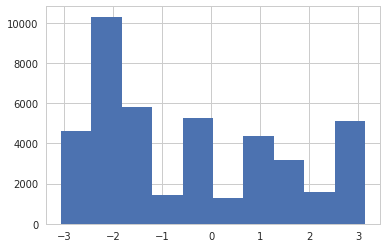

In [535]:
df.angle.hist()

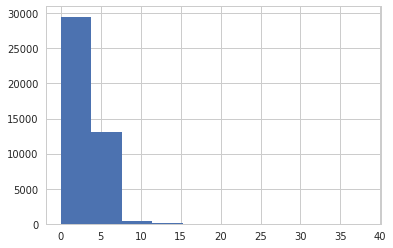

In [536]:
df['size'].hist()

# Clusterizacao do Angulo

In [537]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.externals import joblib

In [538]:
n_clusters=2
X = df[['y1']]

### Kmeans

In [539]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [540]:
cluster_centers_ = kmeans.cluster_centers_.flatten()
cluster_centers_

array([127.57640478, 315.07414282])

In [541]:
df['cluster'] = kmeans.predict(X)

In [542]:
# save
joblib.dump(kmeans, 'kmeans.pkl') 
kmeans = joblib.load('kmeans.pkl') 
kmeans.predict(-1.4)[0]

0

### DBSCAN

In [543]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,342,95,342,96,0,-1,-1.570796,1.0,0
1,5,1,121,119,121,119,0,0,0.000000,0.0,0
2,5,2,195,62,196,62,-1,0,3.141593,1.0,0
3,5,3,565,394,565,395,0,-1,-1.570796,1.0,1
4,5,4,46,7,47,7,-1,0,3.141593,1.0,0


In [544]:
from sklearn.preprocessing import StandardScaler

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(df[['x1', 'y1']])

In [545]:
#dbscan = DBSCAN(eps=0.9, min_samples=50, n_jobs=-1).fit(X)

In [546]:
#labels = dbscan.labels_
#labels

In [547]:
#Number of clusters in labels, ignoring noise if present.
#n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#n_clusters

In [548]:
#df['cluster'] = labels

## Analytics

In [549]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,342,95,342,96,0,-1,-1.570796,1.0,0
1,5,1,121,119,121,119,0,0,0.000000,0.0,0
2,5,2,195,62,196,62,-1,0,3.141593,1.0,0
3,5,3,565,394,565,395,0,-1,-1.570796,1.0,1
4,5,4,46,7,47,7,-1,0,3.141593,1.0,0


In [550]:
#sorted(df.angle.unique())
#math.atan2(y2, x2)

In [551]:
# x1 = 5
# y1 = 5

# x2 = 5
# y2 = -5

# fig, ax = compass([math.atan2(y1, x1), math.atan2(y2, x2)], [1,1,1,1])

In [555]:
# Orientação por Angulo (agrupado)
df_angle = df.groupby(['angle']).agg({'size': 'sum', 'cluster': 'max'}).reset_index()
df_angle.head()

,angle,size,cluster
0,-3.070285,14.035669,1
1,-3.058451,12.041595,1
2,-3.030935,9.055385,1
3,-3.017238,8.062258,1
4,-2.999696,49.497475,1


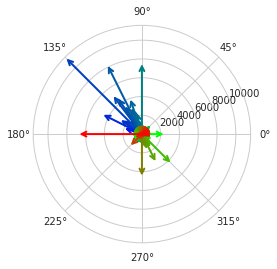

In [556]:
# Todos os Angulos
fig, ax = compass(df_angle.angle.values, df_angle['size'].values)

In [557]:
# Agrupado por cluster
df_cluster = df.groupby(['cluster']).agg('sum').reset_index()
df_cluster.head()

,cluster,frame,i,x1,y1,x2,y2,x,y,angle,size
0,0,6856602,956844,7005446,3010548,7029467,3039482,-24021,-28934,-14960.195469,69895.240143
1,1,5079815,983779,6663191,6110863,6674578,6119121,-11387,-8258,-973.962342,55716.240455


In [446]:
df_cluster['angle'] = df_cluster.apply(lambda row: math.atan2(row.y, row.x), axis=1)

[-2.26368243 -2.51414489]


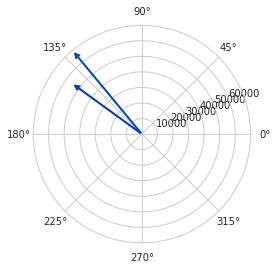

In [447]:
# Angulos do SOmatório
print(df_cluster.angle.values)
fig, ax = compass(df_cluster.angle.values, df_cluster['size'].values)

In [448]:
#  Angulos do centroid do Cluster
#size = [df[df.cluster == c]['size'].sum() for c in range(len(cluster_centers_)) ]
#print(cluster_centers_)
#fig, ax = compass(cluster_centers_, size)

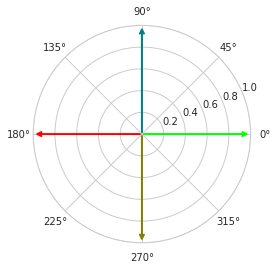

In [449]:
# Todos os Angulos
fig, ax = compass([0, math.pi/2, math.pi, -math.pi/2], [1, 1, 1, 1])

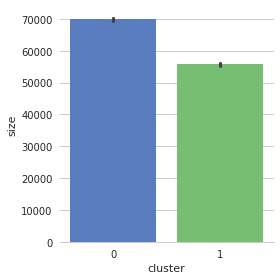

In [450]:
g = sns.factorplot(x="cluster", y="size", data=df, kind="bar", palette="muted", estimator=sum)
g.despine(left=True)

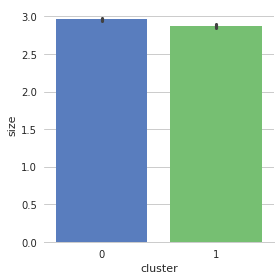

In [451]:
g = sns.factorplot(x="cluster", y="size", data=df, kind="bar", palette="muted")
g.despine(left=True)

In [452]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,342,95,342,96,0,-1,-1.570796,1.0,0
1,5,1,121,119,121,119,0,0,0.000000,0.0,0
2,5,2,195,62,196,62,-1,0,3.141593,1.0,0
3,5,3,565,394,565,395,0,-1,-1.570796,1.0,1
4,5,4,46,7,47,7,-1,0,3.141593,1.0,0


In [453]:
# import matplotlib.pyplot as plt

# ax = plt.axes()
# for i, row in df[df.cluster == 1].iterrows():
#     ax.arrow(row.x1, row.y1, row.x2, row.y2, head_width=0.05, head_length=0.1, fc='k', ec='k')
# #ax.arrow(0, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')

# plt.show()

## Print Arrows Flow

![Image of Yaktocat](sample.png)

In [454]:
   
def plot_arrows(df):
    #Plt
    plt.figure(figsize=(15,10))

    ax = plt.gca()
    ax.invert_yaxis()
    
    #plot
    plt.quiver(df.x1.values, df.y1.values, 
               df.x.values, df.y.values,  
               angles='xy', scale_units='xy', color=[rad2rgb(r) for r in df.angle.values])
    plt.show()
    
def plot_all_arrows(df):
    color = ['b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y']

    #Plt
    plt.figure(figsize=(15,10))

    ax = plt.gca()
    ax.invert_yaxis()
    
    for i in range(n_clusters):
        # Data
        df_arrow = df[df.cluster == i]
        #plot
        plt.quiver(df_arrow.x1.values, df_arrow.y1.values, 
                   df_arrow.x.values, df_arrow.y.values,  
                   angles='xy', scale_units='xy', color=[rad2rgb(r) for r in df_arrow.angle.values])
    plt.show()
#color[i]        

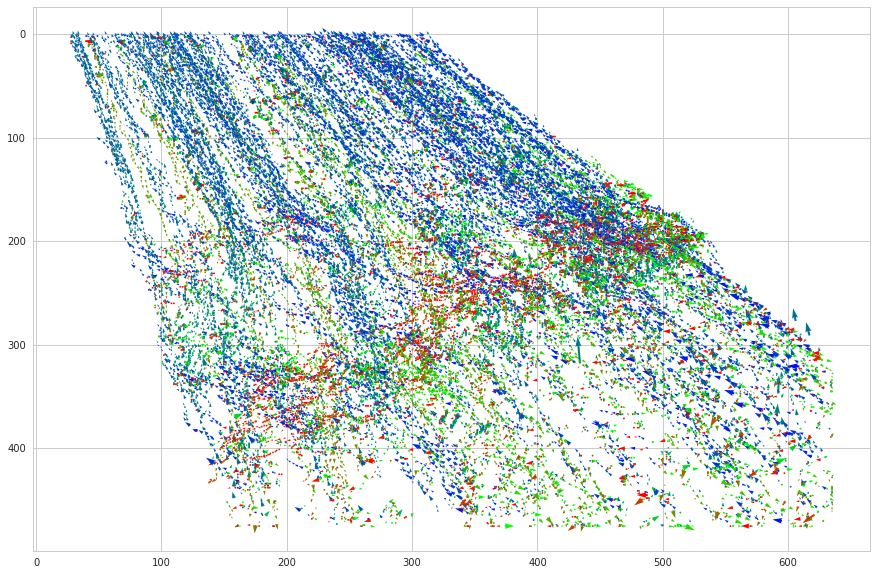

In [558]:
plot_arrows(df)

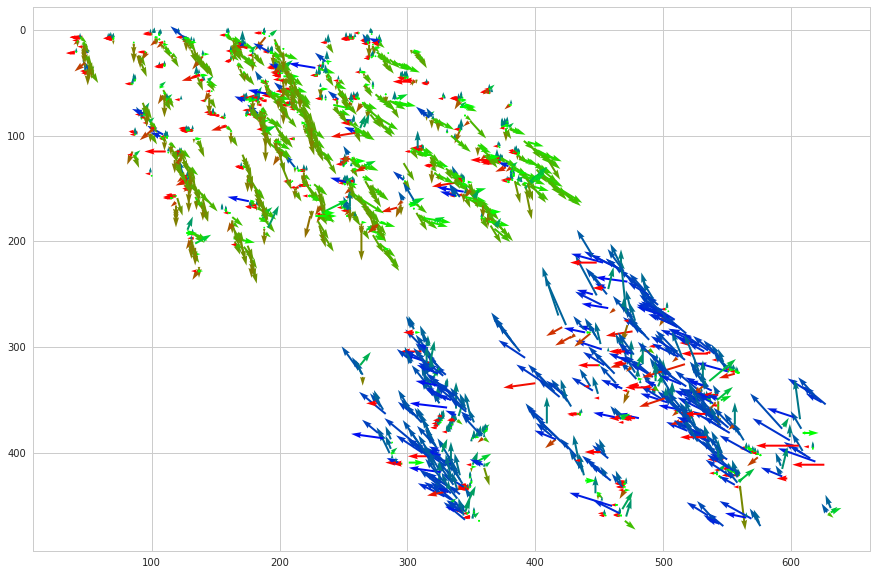

In [472]:
plot_arrows(df[df.frame < 100])

## Block Partiion

Agrupamento por Bloco

In [458]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,342,95,342,96,0,-1,-1.570796,1.0,0
1,5,1,121,119,121,119,0,0,0.000000,0.0,0
2,5,2,195,62,196,62,-1,0,3.141593,1.0,0
3,5,3,565,394,565,395,0,-1,-1.570796,1.0,1
4,5,4,46,7,47,7,-1,0,3.141593,1.0,0


In [520]:
def filter_vec(df, x, y, d):
    return df[(df.x1 >= x-d) & (df.x1 <= x+d) & (df.y1 >= y-d) & (df.y1 <= y+d)]

def next_pos(shape, x, y, d):
    x_max, y_max = shape
    
    x = x + d*2 + 1
    
    if x > x_max:
        x = int(d*2-1)
        y = y + d*2 + 1

    if y >= y_max:
        return [False, x, y]
    
    return [True, x, y]

def block_partition(df, shape, d):
    x_max, y_max = shape
    res = True
    x = int(d*2-1)
    y = int(d*2-1)
    new_vecs = []

    while res:
        df_filter = filter_vec(df, x, y, d)
        if len(df_filter) > 0:
            row   = df_filter.agg('sum')
            angle = math.atan2(row.y, row.x)
            size  = math.sqrt(row.x**2+row.y**2)#/len(df_filter)
            x1    = int(size*math.cos(angle))
            y1    = int(size*math.sin(angle))

            new_vecs.append([x, y, x1, y1, angle, size])

        res, x, y = next_pos(shape, x, y, d)
    return pd.DataFrame(new_vecs, columns=['x1', 'y1', 'x', 'y', 'angle', 'size'])


In [521]:
df_filter = filter_vec(df, 150, 366, 1)
df_filter

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster


In [522]:
df_filter.agg('sum')

frame      0.0
i          0.0
x1         0.0
y1         0.0
x2         0.0
y2         0.0
x          0.0
y          0.0
angle      0.0
size       0.0
cluster    0.0
dtype: float64

In [527]:
img_shape  = (640, 480)
d          = 10  
df_plot    = df#[df.frame > 500]
df_pooling = block_partition(df_plot, img_shape, d)

In [528]:
df_pooling[df_pooling.angle != 0].head()

,x1,y1,x,y,angle,size
0,19,19,-2,-4,-2.034444,4.472136
1,40,19,-125,-275,-2.000433,302.491322
2,61,19,-60,-108,-2.073992,124.422667
3,82,19,-197,-368,-2.064414,417.885152
4,103,19,-218,-353,-2.126078,415.415455


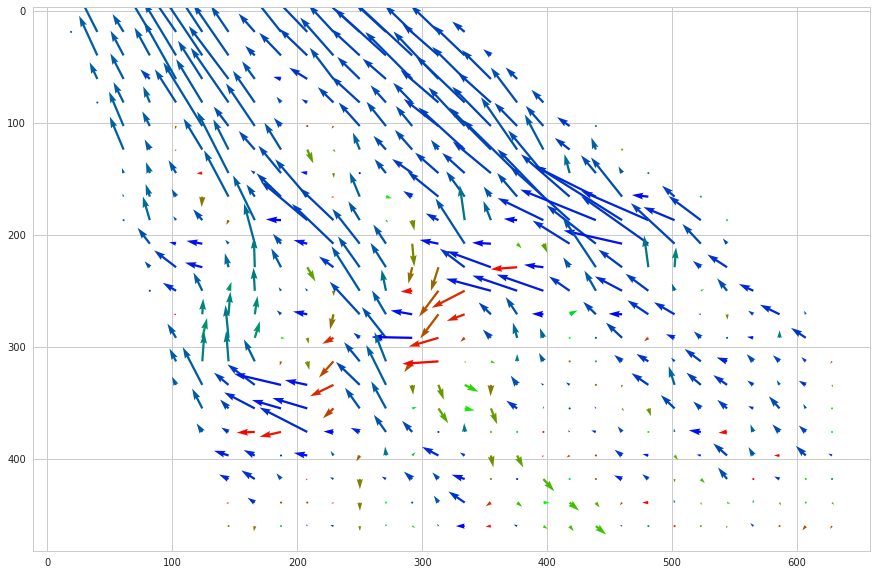

In [529]:
plot_arrows(df_pooling)

In [ ]:
row = df_filter.agg('sum')
row.angle = math.atan2(row.y, row.x)
row['size'] =  math.sqrt(row.x**2+row.y**2)
row

In [497]:
angle = math.atan2(y, x)
size  = math.sqrt(x**2+y**2)

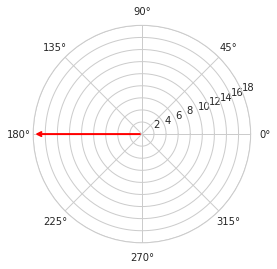

In [371]:
fig, ax = compass([row.angle], [row['size']])